In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
os.environ["LANGSMITH_PROJECT"]="TestProject" ##Creating Project in Langsmith for Tracing

In [3]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"

In [4]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001978A703C20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001978AA4F3E0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [6]:
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}

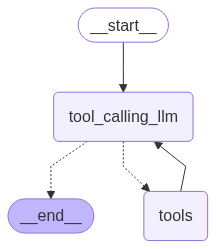

In [7]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:

response=graph.invoke({"messages":"Name top 5 LLM models that have great efficiency"})

In [13]:
response

{'messages': [HumanMessage(content='Name top 5 LLM models that have great efficiency', additional_kwargs={}, response_metadata={}, id='36e6b26a-0319-477b-8229-a29d9a8494c0'),
  AIMessage(content='Here are the top 5 LLM (Large Language Model) models that are known for their great efficiency, along with their characteristics and applications:\n\n1. **BERT (Bidirectional Encoder Representations from Transformers)**:\n\t* Developed by Google in 2018\n\t* Pre-trained on a large corpus of text data using a multi-layer bidirectional transformer encoder\n\t* Efficient in terms of computational resources and memory usage\n\t* Applications: Natural language processing, text classification, sentiment analysis, question answering\n2. **RoBERTa (Robustly Optimized BERT Pretraining Approach)**:\n\t* Developed by Facebook AI in 2019\n\t* A variant of BERT that uses a different approach to pre-training and fine-tuning\n\t* More efficient than BERT in terms of computational resources and memory usage\n

In [14]:
response=graph.invoke({"messages":"what is 7 plus 93"})

In [15]:
response

{'messages': [HumanMessage(content='what is 7 plus 93', additional_kwargs={}, response_metadata={}, id='0ce6bc2d-88c6-46a0-9ccb-e6265ab094aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '40ybqtsm3', 'function': {'arguments': '{"a":7,"b":93}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 898, 'total_tokens': 970, 'completion_time': 0.082713461, 'prompt_time': 0.101352551, 'queue_time': 0.28591749099999997, 'total_time': 0.184066012}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c590a521-c2ba-47f0-9a2b-30f2eb70826d-0', tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 93}, 'id': '40ybqtsm3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 898, 'output_tokens': 72, 'total_tokens': 970}),
  ToolMessage(content='100.0', name='add', id='2d0ef731-59a3-411f-b968-20d3ec9987a6', tool_call_id='40ybqtsm3'),
  AIMes